In [1]:
from dataclasses import dataclass

import torch
import wandb
from torch.utils.data import DataLoader

from dviforbml.architectures.dvi import DVI
from dviforbml.components.cdvi.cmcd import CMCD
from dviforbml.components.cdvi.dis import DIS
from dviforbml.components.control.aggr_control import AggrControl
from dviforbml.components.control.bca_control import BCAControl
from dviforbml.components.control.mhca_control import MHCAControl
from dviforbml.components.encoder.aggr_encoder import Aggr, AggrEncoder
from dviforbml.components.encoder.bca_encoder import BCAEncoder
from dviforbml.components.encoder.mhca_encoder import MHCAEncoder
from dviforbml.components.schedule.annealing_schedule import (
    AggrAnnealingSchedule,
    AnnealingSchedule,
    BCAAnnealingSchedule,
)
from dviforbml.components.schedule.constr_noise_schedule import (
    AggrConstrNoiseSchedule,
    BCAConstrNoiseSchedule,
    ConstrNoiseSchedule,
    MHCAConstrNoiseSchedule,
)
from dviforbml.components.schedule.free_noise_schedule import (
    AggrFreeNoiseSchedule,
    BCAFreeNoiseSchedule,
    FreeNoiseSchedule,
    MHCAFreeNoiseSchedule,
)
from dviforbml.components.schedule.step_size_schedule import StepSizeSchedule
from dviforbml.training.dvi_trainer import DVITrainerContext
from dviforbml.utils.datasets import ContextSetDataset
from dviforbml.utils.distros import TaskPosteriorGMM
from dviforbml.evaluation.visualization.visualize_dvi import visualize_dvi_2d
from dviforbml.components.cdvi.ula import ULA

In [2]:
try:
    import torch_directml

    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

device = torch.device("cpu")

In [3]:
@dataclass
class Config:
    num_steps = 16
    c_dim = 2
    z_dim = 2
    h_dim = 32
    num_layers = 6
    non_linearity = "GELU"
    num_heads_sa = None  # 8
    num_heads_ca = 4
    use_score = False
    learning_rate = 1e-3
    size = 64
    batch_size = 64
    max_context_size = None  # 10  # None
    num_blocks = 1
    aggr = Aggr.MEAN


cfg = Config()

In [4]:
dataset = ContextSetDataset(
    size=cfg.size,
    c_dim=cfg.c_dim,
    max_context_size=10,
    sampling_factor=4,
)

dataloader = DataLoader(dataset=dataset, batch_size=cfg.batch_size, shuffle=True)

In [5]:
contextual_target = TaskPosteriorGMM

aggr_encoder = AggrEncoder(
    c_dim=cfg.c_dim,
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    num_heads=cfg.num_heads_sa,
    num_blocks=cfg.num_blocks,
    max_context_size=cfg.max_context_size,
    aggregation=cfg.aggr,
)

bca_encoder = BCAEncoder(
    c_dim=cfg.c_dim,
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    num_heads=cfg.num_heads_sa,
    num_blocks=cfg.num_blocks,
    max_context_size=cfg.max_context_size,
    bca_dim=cfg.h_dim,
)

mhca_encoder = MHCAEncoder(
    z_dim=cfg.z_dim,
    c_dim=cfg.c_dim,
    h_dim=cfg.h_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    num_heads=cfg.num_heads_sa,
    num_blocks=cfg.num_blocks,
    max_context_size=cfg.max_context_size,
)

aggr_control = AggrControl(
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    max_context_size=cfg.max_context_size,
    num_steps=cfg.num_steps,
    use_score=cfg.use_score,
)

bca_control = BCAControl(
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    max_context_size=cfg.max_context_size,
    num_steps=cfg.num_steps,
    use_score=cfg.use_score,
)

mhca_control = MHCAControl(
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    max_context_size=cfg.max_context_size,
    num_steps=cfg.num_steps,
    use_score=cfg.use_score,
    num_heads=cfg.num_heads_ca,
)

step_size_schedule = StepSizeSchedule(num_steps=cfg.num_steps, device=device)

free_noise_sched = FreeNoiseSchedule(
    z_dim=cfg.z_dim,
    num_steps=cfg.num_steps,
    device=device,
)

aggr_free_noise_sched = AggrFreeNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    max_context_size=cfg.max_context_size,
    device=device,
)

bca_free_noise_sched = BCAFreeNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    max_context_size=cfg.max_context_size,
    device=device,
)

mhca_free_noise_sched = MHCAFreeNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    num_heads=cfg.num_heads_ca,
    max_context_size=cfg.max_context_size,
    device=device,
)

constr_noise_sched = ConstrNoiseSchedule(
    z_dim=cfg.z_dim,
    num_steps=cfg.num_steps,
    device=device,
)

aggr_constr_noise_sched = AggrConstrNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    max_context_size=cfg.max_context_size,
)

bca_constr_noise_schede = BCAConstrNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    max_context_size=cfg.max_context_size,
)

mhca_constr_noise_sched = MHCAConstrNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    num_heads=cfg.num_heads_ca,
    max_context_size=cfg.max_context_size,
    device=device,
)

# anneal_sched = AnnealingSchedule(num_steps=cfg.num_steps, device=device)

# aggr_anneal_schedule = AggrAnnealingSchedule(
#     z_dim=cfg.z_dim,
#     h_dim=cfg.h_dim,
#     num_steps=cfg.num_steps,
#     num_layers=cfg.num_layers,
#     non_linearity=cfg.non_linearity,
#     max_context_size=cfg.max_context_size,
#     device=device,
# )

# bca_anneal_schedule = BCAAnnealingSchedule(
#     z_dim=cfg.z_dim,
#     h_dim=cfg.h_dim,
#     num_steps=cfg.num_steps,
#     num_layers=cfg.num_layers,
#     non_linearity=cfg.non_linearity,
#     max_context_size=cfg.max_context_size,
#     device=device,
# )


comps = (
    aggr_encoder,
    aggr_control,
    aggr_free_noise_sched,
    None,
)

# comps = (
#     bca_encoder,
#     bca_control,
#     bca_cos_noise_schedule,
#     bca_annealing_schedule,
# )

# comps = (
#     mhca_encoder,
#     mhca_control,
#     mhca_noise_schedule,
#     None,
# )

cdvi = DIS(
    z_dim=cfg.z_dim,
    num_steps=cfg.num_steps,
    control=comps[1],
    step_size_schedule=step_size_schedule,
    noise_schedule=comps[2],
    annealing_schedule=comps[3],
    use_score=cfg.use_score,
    device=device,
)

# cdvi = CMCD(
#     z_dim=cfg.z_dim,
#     num_steps=cfg.num_steps,
#     control=comps[1],
#     step_size_schedule=step_size_schedule,
#     noise_schedule=comps[2],
#     annealing_schedule=comps[3],
#     device=device,
# )

# cdvi = ULA(
#     z_dim=cfg.z_dim,
#     num_steps=cfg.num_steps,
#     step_size_schedule=step_size_schedule,
#     noise_schedule=comps[2],
#     annealing_schedule=comps[3],
#     device=device,
# )

model = DVI(encoder=comps[0], cdvi=cdvi, contextual_target=contextual_target).to(device)

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)

trainer = DVITrainerContext(
    model=model,
    device=device,
    dataset=dataset,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    generator=torch.Generator(device=device),
    wandb_logging=False,
    num_subtasks=32,
    num_samples=32,
    val_grad_off=True,
)

print(model)

DVI(
  (encoder): AggrEncoder(
    (proj_in): Linear(in_features=2, out_features=32, bias=True)
    (blocks): ModuleList(
      (0): EncoderBlock(
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=32, bias=True)
          (3): GELU(approximate='none')
          (4): Linear(in_features=32, out_features=32, bias=True)
          (5): GELU(approximate='none')
          (6): Linear(in_features=32, out_features=32, bias=True)
          (7): GELU(approximate='none')
          (8): Linear(in_features=32, out_features=32, bias=True)
          (9): GELU(approximate='none')
          (10): Linear(in_features=32, out_features=32, bias=True)
          (11): GELU(approximate='none')
          (12): Linear(in_features=32, out_features=32, bias=True)
        )
      )
    )
  )
  (cdvi): DIS(
    (control): AggrControl(
      (proj_n): Embedding(17, 2)
      (mlp): Sequ

In [7]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="local-toytaskposterior", name="mhca")

In [8]:
# trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.learning_rate
train = False
if train:
    num_epochs = 2000
    losses = trainer.train(num_epochs=num_epochs, max_clip_norm=None, alpha=None)

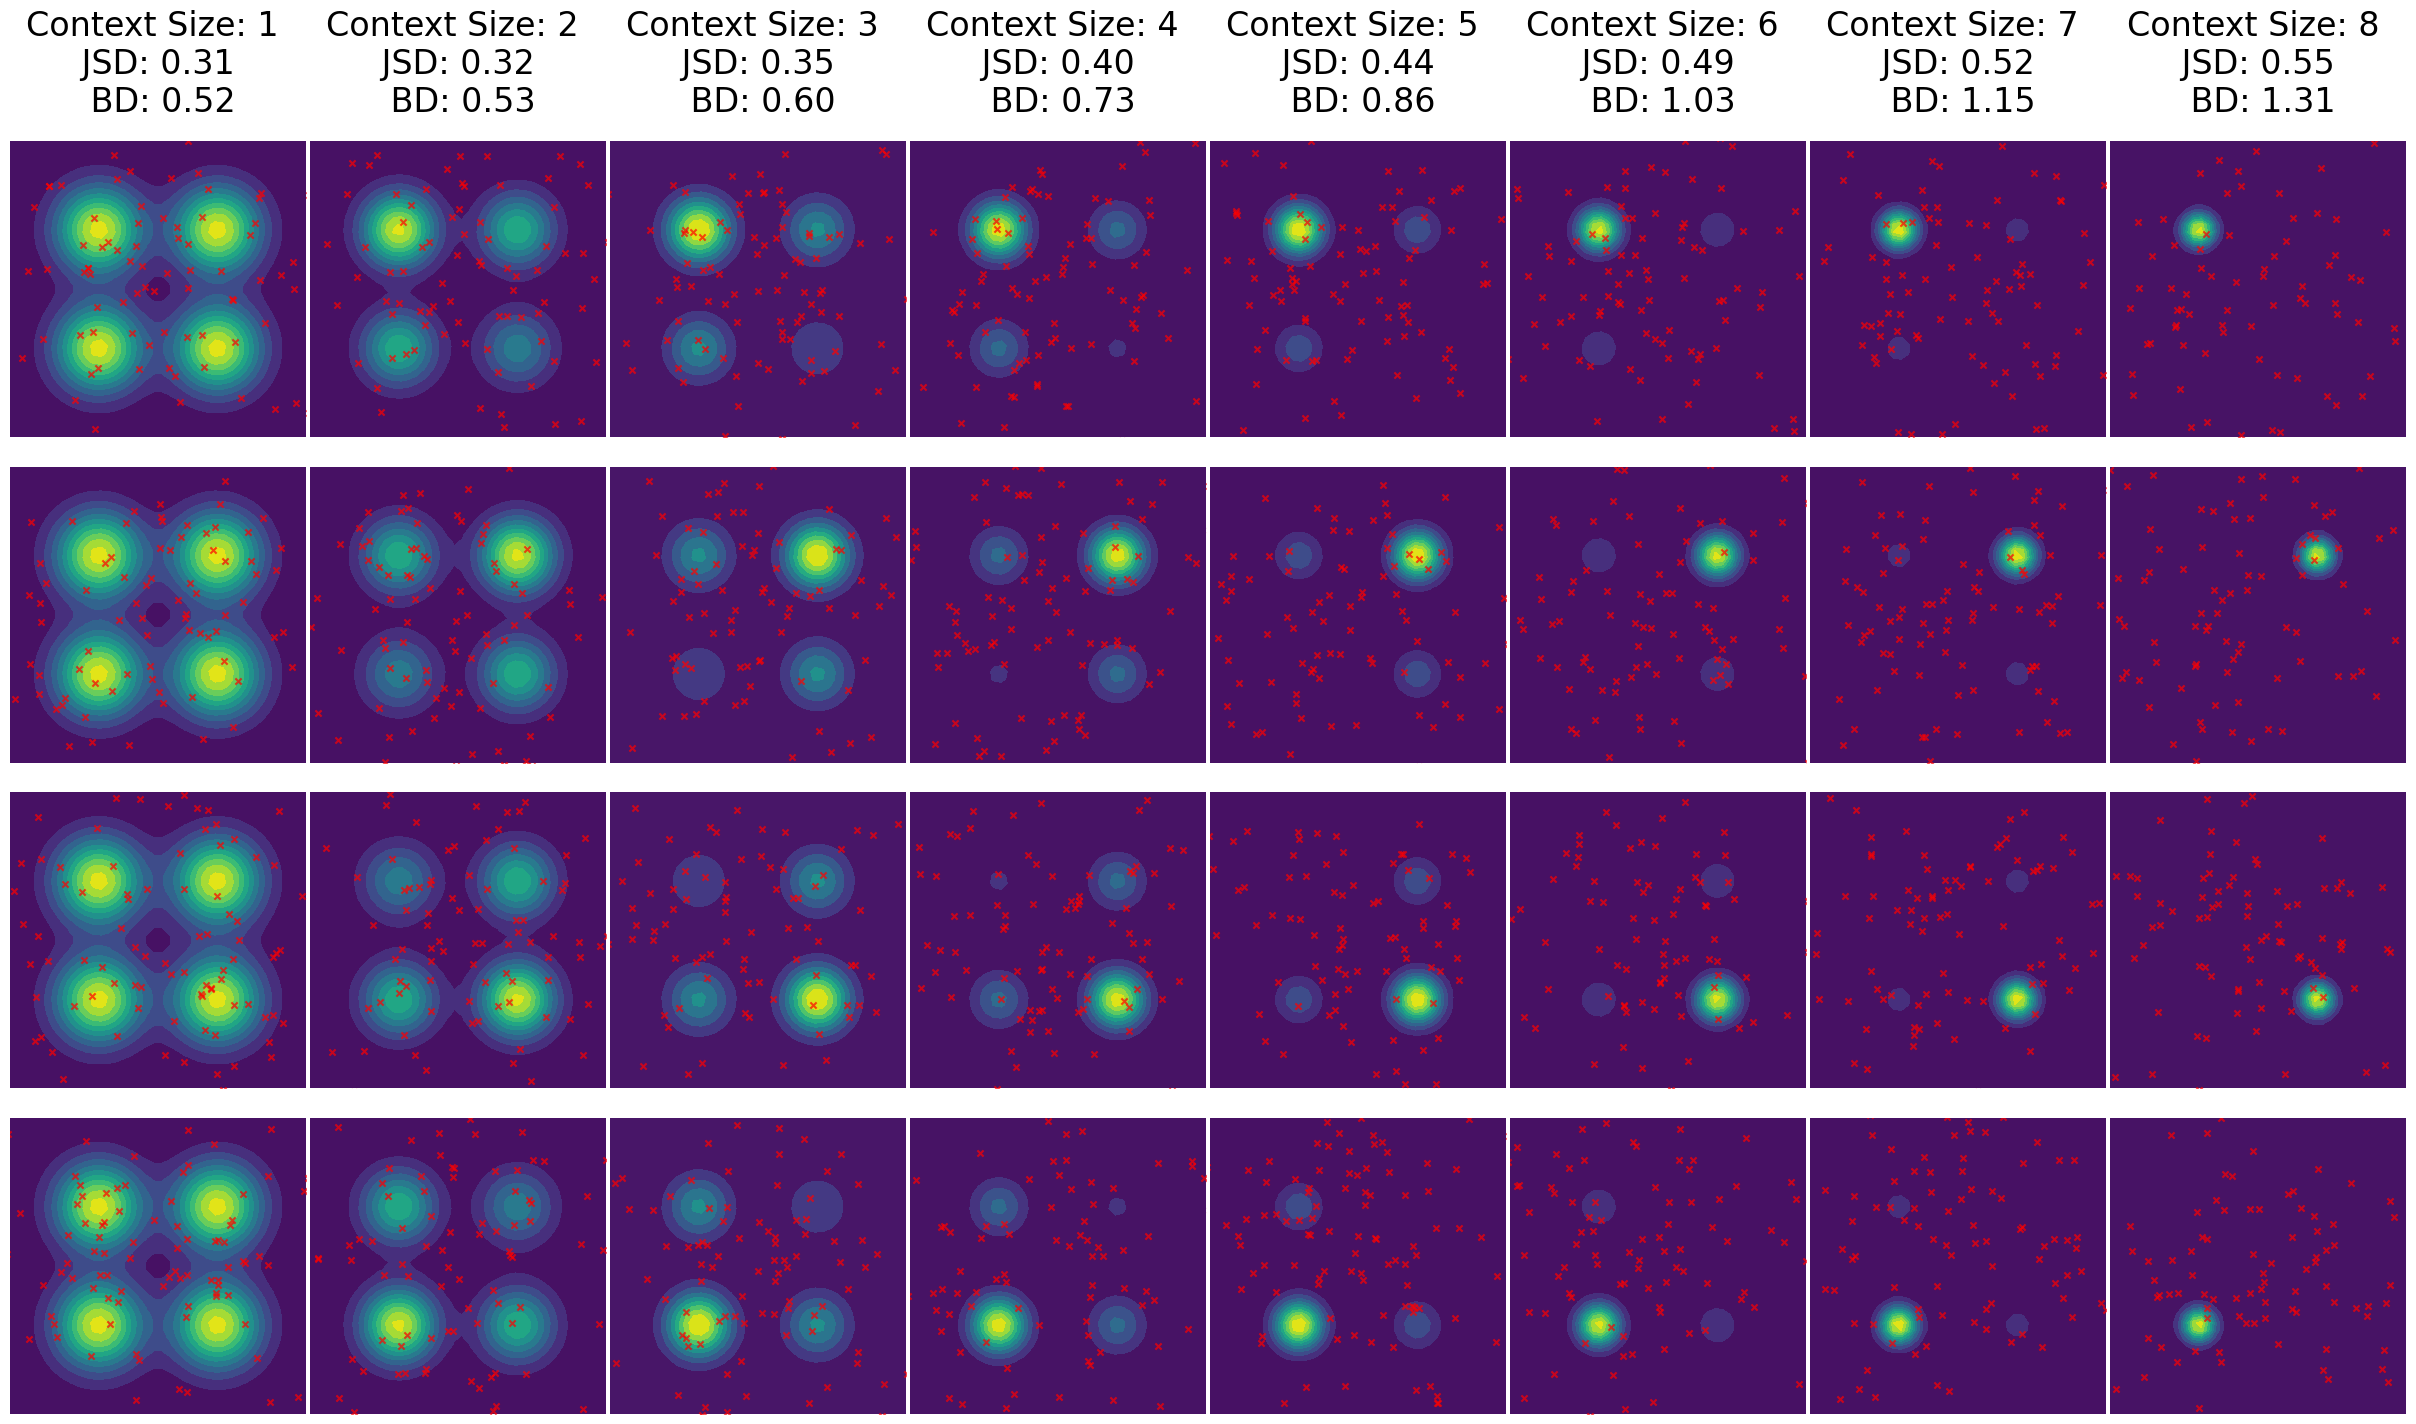

In [9]:
from dviforbml.evaluation.visualization.visualize_dvi_contour import (
    visualize_dvi_2d_contour_all,
)


# visualize_dvi_2d(device, model, dataset, multipliers=(1, 1))
visualize_dvi_2d_contour_all(device, model, dataset)